In [1]:
# plotting.py
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import glob

sys.path.append("/home/jovyan/camels/proj1/")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution, get_safe_name, get_colour_dir_name, get_magnitude_mask
from variables_config import get_config



In [2]:

def get_simulation_color(simulation):
    """Get standard color for each simulation"""
    color_map = {
        "IllustrisTNG": "blue",
        "SIMBA": "green",
        "Astrid": "red",
        "Swift-EAGLE": "orange"
    }
    return color_map.get(simulation, "gray")


In [3]:
def load_simulation_data(simulations, config):
    """Load existing data files without creating plots."""
    all_uvlf_data = {}
    all_colour_data = {}
    
    for simulation in simulations:
        config = get_config(dataset="CV", simulation=simulation)
        sim_uvlf_data = {}
        sim_colour_data = {}
        
        # Load UVLF data
        for snap, redshift_info in config["redshift_values"].items():
            z_data = {}
            for category in ['intrinsic', 'attenuated']:
                for band in config["filters"][category]:
                    filter_system = get_safe_name(band, filter_system_only=True)
                    data_dir = os.path.join(config["lf_data_dir"][category][filter_system],
                                          get_safe_name(redshift_info['label']))
                    
                    # Modified to look for CV_* files
                    pattern = f"UVLF_CV_*_{get_safe_name(band)}_{redshift_info['label']}_{category}.txt"
                    file_list = glob.glob(os.path.join(data_dir, pattern))
                    
                    if file_list:
                        all_data = []
                        for filename in file_list:
                            try:
                                data = pd.read_csv(filename, sep='\t')
                                all_data.append(data)
                            except Exception as e:
                                print(f"Error loading {filename}: {e}")
                        
                        if all_data:
                            if category not in z_data:
                                z_data[category] = {}
                            z_data[category]['magnitude'] = all_data[0]['magnitude'].values
                            z_data[category]['phi'] = np.array([df['phi'].values for df in all_data])
            
            if z_data:
                sim_uvlf_data[redshift_info['redshift']] = z_data
        
        # Similar modification for colour data
        for band1, band2 in config["colour_pairs"]:
            filter_system = get_colour_dir_name(band1, band2)
            for category in ['intrinsic', 'attenuated']:
                for snap, redshift_info in config["redshift_values"].items():
                    data_dir = os.path.join(config["colour_data_dir"][category],
                                          filter_system,
                                          get_safe_name(redshift_info['label']))
                    
                    pattern = f"Colour_CV_*_{filter_system}_{redshift_info['label']}_{category}.txt"
                    file_list = glob.glob(os.path.join(data_dir, pattern))
                    
                    if file_list:
                        all_data = []
                        for filename in file_list:
                            try:
                                data = pd.read_csv(filename, sep='\t')
                                all_data.append(data)
                            except Exception as e:
                                print(f"Error loading {filename}: {e}")
                        
                        if all_data:
                            if f'{band1}-{band2}' not in sim_colour_data:
                                sim_colour_data[f'{band1}-{band2}'] = {}
                            if redshift_info['redshift'] not in sim_colour_data[f'{band1}-{band2}']:
                                sim_colour_data[f'{band1}-{band2}'][redshift_info['redshift']] = {}
                            sim_colour_data[f'{band1}-{band2}'][redshift_info['redshift']][category] = {
                                'colour': all_data[0]['colour'].values,
                                'distribution': np.array([df['distribution'].values for df in all_data])
                            }
        
        all_uvlf_data[simulation] = sim_uvlf_data
        all_colour_data[simulation] = sim_colour_data
    
    return all_uvlf_data, all_colour_data

In [4]:

def plot_cv_uvlf(input_dir, redshift_label, band, category, simulation):
    """Plot UVLF for CV simulations showing mean, scatter, and individual runs."""
    pattern = f"UVLF_CV_*_{get_safe_name(band)}_{redshift_label}_{category}.txt"
    files = glob.glob(os.path.join(input_dir, pattern))
    
    if not files:
        return None, None, None
    
    all_data = []
    for f in files:
        try:
            df = pd.read_csv(f, sep='\t')
            all_data.append(df)
        except Exception as e:
            continue
    
    if not all_data:
        return None, None, None
    
    magnitudes = all_data[0]['magnitude'].values
    phi_arrays = np.array([df['phi'].values for df in all_data])
    phi_sigma_arrays = np.array([df['phi_sigma'].values for df in all_data])
    
    mean_phi = np.mean(phi_arrays, axis=0)
    std_phi = np.std(phi_arrays, axis=0)
    #lower_percentile = np.percentile(phi_arrays, 16, axis=0)
    #upper_percentile = np.percentile(phi_arrays, 84, axis=0)
    
    sim_color = get_simulation_color(simulation)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for phi in phi_arrays:
        ax.plot(magnitudes, phi, '-', color=sim_color, alpha=0.1)
    
    ax.plot(magnitudes, mean_phi, '-', color=sim_color, linewidth=2, 
            label=f'{simulation} Mean UVLF')
    #ax.fill_between(magnitudes, lower_percentile, upper_percentile,
    #               alpha=0.3, color=sim_color, label='16th-84th Percentile')
    
    ax.errorbar(magnitudes, mean_phi, yerr=std_phi/np.sqrt(len(all_data)),
               fmt='none', ecolor=sim_color, capsize=5)
    
    ax.set_xlabel('M$_{UV}$ [AB mag]', fontsize=12)
    ax.set_ylabel('log$_{10}$ φ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=12)
    ax.set_title(f'{simulation} {band} UVLF\n{category}, {redshift_label}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return fig, magnitudes, mean_phi




In [5]:
def plot_cv_uvlf(magnitudes, phi_arrays, redshift_label, band, category, simulation):
    """Plot UVLF for CV simulations showing mean, scatter, and individual runs."""
    if magnitudes is None or phi_arrays is None:
        return None, None, None
    
    mean_phi = np.mean(phi_arrays, axis=0)
    std_phi = np.std(phi_arrays, axis=0)
    
    sim_color = get_simulation_color(simulation)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for phi in phi_arrays:
        ax.plot(magnitudes, phi, '-', color=sim_color, alpha=0.1)
    
    ax.plot(magnitudes, mean_phi, '-', color=sim_color, linewidth=2, 
            label=f'{simulation} Mean UVLF')
    
    ax.errorbar(magnitudes, mean_phi, yerr=std_phi/np.sqrt(len(phi_arrays)),
               fmt='none', ecolor=sim_color, capsize=5)
    
    ax.set_xlabel('M$_{UV}$ [AB mag]', fontsize=12)
    ax.set_ylabel('log$_{10}$ φ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=12)
    ax.set_title(f'{simulation} {band} UVLF\n{category}, {redshift_label}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return fig, magnitudes, mean_phi


In [6]:

def plot_cv_colours(colours, dist_arrays, redshift_label, band1, band2, category, simulation):
    """Plot colour distributions for CV simulations."""
    if colours is None or dist_arrays is None:
        return None, None, None
    
    mean_dist = np.mean(dist_arrays, axis=0)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sim_color = get_simulation_color(simulation)
    for dist in dist_arrays:
        ax.plot(colours, dist, '-', color=sim_color, alpha=0.2)
    
    ax.plot(colours, mean_dist, '-', color=sim_color, linewidth=2, 
            label=simulation)
    
    ax.set_xlabel(f'{band1} - {band2} [mag]', fontsize=12)
    ax.set_ylabel('Normalized Count', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True)
    
    return fig, colours, mean_dist

In [7]:
def plot_combined_colours(all_sims_data, redshifts, output_dir, colour_pairs):
    """Create combined colour plot showing all simulations."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for sim_name, sim_data in all_sims_data.items():
        color = get_simulation_color(sim_name)
        if sim_data:
            # Get first colour pair's data (assuming we're just plotting FUV-NUV)
            colour_key = list(sim_data.keys())[0]
            # Get first redshift's data (or specific redshift if needed)
            z_data = list(sim_data[colour_key].values())[0]
            
            if 'intrinsic' in z_data:
                ax.plot(z_data['intrinsic']['colour'], 
                       z_data['intrinsic']['distribution'],
                       '-', color=color, label=sim_name)
    
    ax.set_xlabel('GALEX FUV - GALEX NUV [mag]', fontsize=12)
    ax.set_ylabel('Normalized Count', fontsize=12)
    ax.set_xlim(-0.5, 3.5)
    
    # Get current y limits
    ymin, ymax = ax.get_ylim()
    # Force y axis to start at 0 while maintaining the upper limit
    ax.set_ylim(0, ymax)
    
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True)
    
    output_file = os.path.join(output_dir, 'combined_colours.pdf')
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()

In [8]:
def plot_combined_uvlf(all_sims_data, redshifts, output_dir):
    """Create a multi-panel plot showing UVLFs for all simulations at different redshifts."""
    num_redshifts = len(redshifts)
    # Increase figure width
    fig, axes = plt.subplots(1, num_redshifts, figsize=(20, 4))  # Changed from 16 to 20
    if num_redshifts == 1:
        axes = [axes]
    
    plotted_sims = []
    
    for ax, redshift_info in zip(axes, redshifts):
        z = redshift_info['redshift']
        
        for sim_name, sim_data in all_sims_data.items():
            color = get_simulation_color(sim_name)
            
            if z in sim_data:
                z_data = sim_data[z]
                
                if 'intrinsic' in z_data:
                    ax.plot(z_data['intrinsic']['magnitude'], 
                           z_data['intrinsic']['phi'],
                           '--', color=color, alpha=0.5)
                
                if 'attenuated' in z_data:
                    label = sim_name if sim_name not in plotted_sims else None
                    ax.plot(z_data['attenuated']['magnitude'], 
                           z_data['attenuated']['phi'],
                           '-', color=color,
                           label=label)
                    if label:
                        plotted_sims.append(sim_name)
        
        ax.set_xlabel('M$_{AB}$', fontsize=10)
        ax.set_ylabel('$\phi$ [Mpc$^{-3}$ dex$^{-1}$]' if ax == axes[0] else '', fontsize=10)
        ax.set_ylim(-5.0, -2.0)
        
        # Get current auto-set x limits
        current_xlim = ax.get_xlim()
        ax.set_xlim(left=current_xlim[0], right=-14)
        
        ax.grid(True, alpha=0.3)
        ax.text(0.05, 0.95, f'z = {z}', transform=ax.transAxes, 
                fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    fig.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', 
              fontsize=10, frameon=True)
    
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(os.path.join(output_dir, 'combined_uvlf.pdf'), 
                bbox_inches='tight', dpi=300)
    plt.close()


In [9]:

def plot_individual_redshift_uvlfs(all_sims_data, redshifts, output_dir):
    """Create separate plots for each redshift's UVLF."""
    for redshift_info in redshifts:
        z = redshift_info['redshift']
        
        fig, ax = plt.subplots(figsize=(8, 6))
        plotted_sims = []
        
        for sim_name, sim_data in all_sims_data.items():
            color = get_simulation_color(sim_name)
            
            if z in sim_data:
                z_data = sim_data[z]
                
                if 'intrinsic' in z_data:
                    ax.plot(z_data['intrinsic']['magnitude'], 
                           z_data['intrinsic']['phi'],
                           '--', color=color, alpha=0.5)
                
                if 'attenuated' in z_data:
                    label = sim_name
                    ax.plot(z_data['attenuated']['magnitude'], 
                           z_data['attenuated']['phi'],
                           '-', color=color,
                           label=label)
        
        ax.set_xlabel('M$_{AB}$', fontsize=12)
        ax.set_ylabel('$\phi$ [Mpc$^{-3}$ dex$^{-1}$]', fontsize=12)
        ax.set_ylim(-5.0, -2.0)
        
        # Get current auto-set x limits
        current_xlim = ax.get_xlim()
        ax.set_xlim(left=current_xlim[0], right=-14)
        
        ax.grid(True, alpha=0.3)
        ax.set_title(f'z = {z}', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                 fontsize=10, frameon=True)
        
        # Save individual plot
        individual_dir = os.path.join(output_dir, 'individual_redshifts')
        os.makedirs(individual_dir, exist_ok=True)
        plt.savefig(os.path.join(individual_dir, f'uvlf_z{redshift_info["label"]}.pdf'), 
                    bbox_inches='tight', dpi=300)
        plt.close()

In [10]:
def create_individual_plots(simulations, config):
    """Create individual UVLF and colour plots for each simulation."""
    all_uvlf_data = {}
    all_colour_data = {}
    
    for simulation in simulations:
        print(f"\nProcessing simulation: {simulation}")
        config = get_config(dataset="CV", simulation=simulation)
        
        # Initialize simulation data
        sim_uvlf_data = {}
        sim_colour_data = {}
        
        # Process UVLFs
        for snap, redshift_info in config["redshift_values"].items():
            print(f"\nProcessing redshift: {redshift_info['label']}")
            z_data = {}
            
            # UVLF plots
            for category in ['intrinsic', 'attenuated']:
                for band in config["filters"][category]:
                    print(f"Processing {category} {band}")
                    filter_system = get_safe_name(band, filter_system_only=True)
                    data_dir = os.path.join(config["lf_data_dir"][category][filter_system],
                                          get_safe_name(redshift_info['label']))
                    
                    fig, magnitudes, mean_phi = plot_cv_uvlf(
                        input_dir=data_dir,
                        redshift_label=redshift_info['label'],
                        band=band,
                        category=category,
                        simulation=simulation
                    )
                    
                    if fig is not None:
                        plot_output_dir = config["plots_dir"]["UVLFs"][category]
                        os.makedirs(plot_output_dir, exist_ok=True)
                        output_file = os.path.join(
                            plot_output_dir,
                            f"UVLF_{simulation}_{get_safe_name(band)}_{redshift_info['label']}_{category}.pdf"
                        )
                        print(f"Saving UVLF plot to: {output_file}")
                        fig.savefig(output_file, bbox_inches='tight', dpi=300)
                        plt.close(fig)
                    
                    if magnitudes is not None and mean_phi is not None:
                        if category not in z_data:
                            z_data[category] = {}
                        z_data[category]['magnitude'] = magnitudes
                        z_data[category]['phi'] = mean_phi
            
            sim_uvlf_data[redshift_info['redshift']] = z_data

            # Colour plots
            for category in ['intrinsic', 'attenuated']:
                for band1, band2 in config["colour_pairs"]:
                    print(f"Processing colours {band1}-{band2} for {category}")
                    filter_system = get_colour_dir_name(band1, band2)
                    data_dir = os.path.join(config["colour_data_dir"][category],
                                          filter_system,
                                          get_safe_name(redshift_info['label']))
                    
                    fig, colours, mean_dist = plot_cv_colours(
                        input_dir=data_dir,
                        redshift_label=redshift_info['label'],
                        band1=band1,
                        band2=band2,
                        category=category,
                        simulation=simulation
                    )
                    
                    if fig is not None:
                        plot_output_dir = config["plots_dir"]["colours"][category]
                        os.makedirs(plot_output_dir, exist_ok=True)
                        output_file = os.path.join(
                            plot_output_dir,
                            f"Colour_{simulation}_{filter_system}_{redshift_info['label']}_{category}.pdf"
                        )
                        print(f"Saving colour plot to: {output_file}")
                        fig.savefig(output_file, bbox_inches='tight', dpi=300)
                        plt.close(fig)
                    
                    if colours is not None and mean_dist is not None:
                        if f'{band1}-{band2}' not in sim_colour_data:
                            sim_colour_data[f'{band1}-{band2}'] = {}
                        if redshift_info['redshift'] not in sim_colour_data[f'{band1}-{band2}']:
                            sim_colour_data[f'{band1}-{band2}'][redshift_info['redshift']] = {}
                        sim_colour_data[f'{band1}-{band2}'][redshift_info['redshift']][category] = {
                            'colour': colours,
                            'distribution': mean_dist
                        }
        
        print(f"\nStoring data for {simulation}")
        all_uvlf_data[simulation] = sim_uvlf_data
        all_colour_data[simulation] = sim_colour_data
    
    return all_uvlf_data, all_colour_data


In [11]:
def create_individual_plots(loaded_data, config, output_dir):
    """Create individual plots for each simulation from loaded data."""
    all_uvlf_data, all_colour_data = loaded_data
    
    for simulation in all_uvlf_data:
        print(f"\nProcessing plots for {simulation}")
        sim_uvlf_data = all_uvlf_data[simulation]
        
        # Process UVLFs
        for redshift, z_data in sim_uvlf_data.items():
            redshift_info = next(info for info in config["redshift_values"].values() 
                               if info['redshift'] == redshift)
            
            for category in ['intrinsic', 'attenuated']:
                if category in z_data:
                    magnitudes = z_data[category]['magnitude']
                    phi = z_data[category]['phi']
                    
                    fig, _, _ = plot_cv_uvlf(
                        magnitudes=magnitudes,
                        phi_arrays=[phi],  # Wrap in list since we have single array
                        redshift_label=redshift_info['label'],
                        band="GALEX FUV",  # Or whatever band you're using
                        category=category,
                        simulation=simulation
                    )
                    
                    if fig is not None:
                        plot_output_dir = os.path.join(output_dir, simulation, "UVLFs", category)
                        os.makedirs(plot_output_dir, exist_ok=True)
                        output_file = os.path.join(
                            plot_output_dir,
                            f"UVLF_{simulation}_{redshift_info['label']}_{category}.pdf"
                        )
                        fig.savefig(output_file, bbox_inches='tight', dpi=300)
                        plt.close(fig)



ValueError: x and y must have same first dimension, but have shapes (12,) and (27, 12)

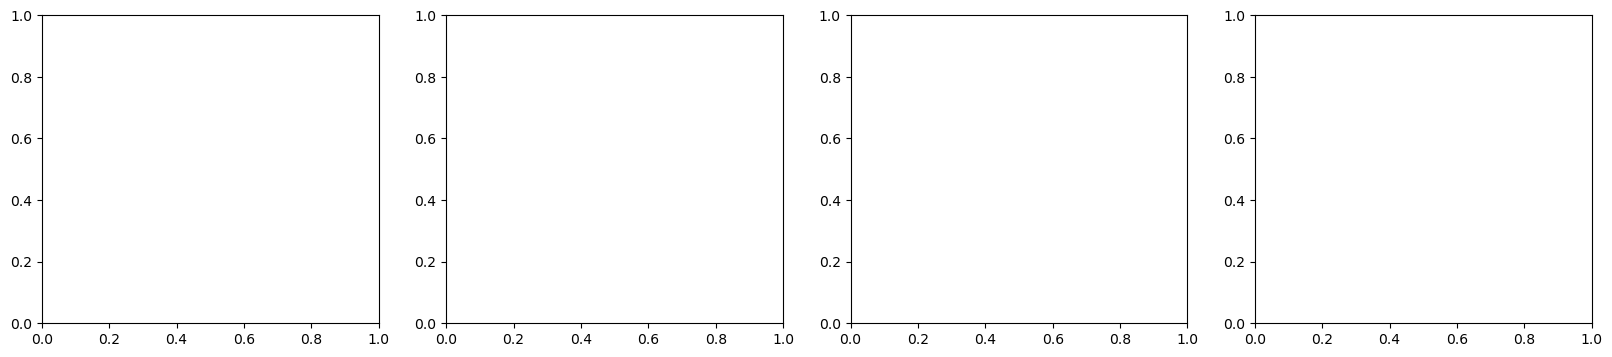

In [12]:
def main():
    simulations = ["IllustrisTNG", "SIMBA", "Astrid", "Swift-EAGLE"]
    config = get_config(dataset="CV", simulation=simulations[0])
    base_plots_dir = os.path.join("/home/jovyan/camels/proj1/CV_set/CV_outputs/plots")

    # Choose what you want to do
    MAKE_INDIVIDUAL_PLOTS = False
    MAKE_COMBINED_PLOTS = True
    
    # Load the data
    loaded_data = load_simulation_data(simulations, config)
    
    # Create plots based on flags
    if MAKE_INDIVIDUAL_PLOTS:
        create_individual_plots(loaded_data, config, base_plots_dir)
    
    if MAKE_COMBINED_PLOTS:
        combined_plot_dir = os.path.join(base_plots_dir, "combined")
        os.makedirs(combined_plot_dir, exist_ok=True)
        
        # Create combined plots
        plot_combined_uvlf(loaded_data[0],  # UVLF data 
                         sorted(config["redshift_values"].values(), key=lambda x: x['redshift']),
                         combined_plot_dir)
        
        plot_combined_colours(loaded_data[1],  # Colour data
                           sorted(config["redshift_values"].values(), key=lambda x: x['redshift']),
                           combined_plot_dir,
                           config["colour_pairs"])

if __name__ == "__main__":
    main()